# Prompt Explorer

This is a notebook for exploring prompts and seeds. Random seeds are generated and displayed. The idea is to have this running alongside other more complicated notebooks, but this one doesn't needs to have gdrive connection. Then when finding cool prompt/seed combos, but them in the prompts google sheet and have those more complex notebooks reference the sheet vs defining prompts as variables in the code.

In [1]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/gdrive')

song_name = 'cycle' #@param {type:"string"}
res_height = 576 #@param
res_width = 1024 #@param

code_folder = '/content/gdrive/MyDrive/AI-Art Kyle'

# fp = os.path.join(code_folder, 'input_data.xlsx')
# df_prompt = pd.read_excel(fp, 'prompts_{}'.format(song_name), index_col=0).dropna(how='all')
# df_prompt

fp = os.path.join(code_folder, song_name, 'prompt_data', 'prompt_image_definitions.csv')
df_prompt = pd.read_csv(fp, index_col=0).dropna(how='all')

Mounted at /content/gdrive


In [2]:
%%capture
!pip install diffusers
!pip install transformers scipy ftfy accelerate

import torch
from diffusers import StableDiffusionPipeline

In [30]:

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",
                                               torch_dtype=torch.float16,
                                               safety_checker=None
                                               )
# pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1",
#                                                torch_dtype=torch.float16,
#                                                safety_checker=None
#                                                )

pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [249]:
fp = os.path.join(code_folder, song_name, 'prompt_data', 'prompt_image_definitions.csv')
df_prompt = pd.read_csv(fp, index_col=0).dropna(how='all')
df_prompt

prompt_name = 'swamp_sinking_fire' #@param {type:"string"}
prompt = df_prompt['prompt'][prompt_name]
guidance_scale = float(df_prompt['guidance_scale'][prompt_name])
negative_prompt = df_prompt['negative_prompt'][prompt_name]
if negative_prompt != negative_prompt: negative_prompt = None
print("Prompt: {}".format(prompt))

Prompt: a burning forest with white smoke plumes, glowing embers, toxic white flames chasing a man in a white hazmat suit with no helmet, hellscape, on hands and knees in the mud, crawling in a smoldering forest swamp by a single tree, dark, silhouettes of trees in the background


Prompt: a burning forest with white smoke plumes, glowing embers, toxic white flames chasing a man in a white hazmat suit with no helmet, hellscape, on hands and knees in the mud, crawling in a smoldering forest swamp by a single tree, dark, silhouettes of trees in the background
Seeds: [6849731602212562, 8504857472398256, 7056166301261809, 4397641022016206]


  0%|          | 0/50 [00:00<?, ?it/s]

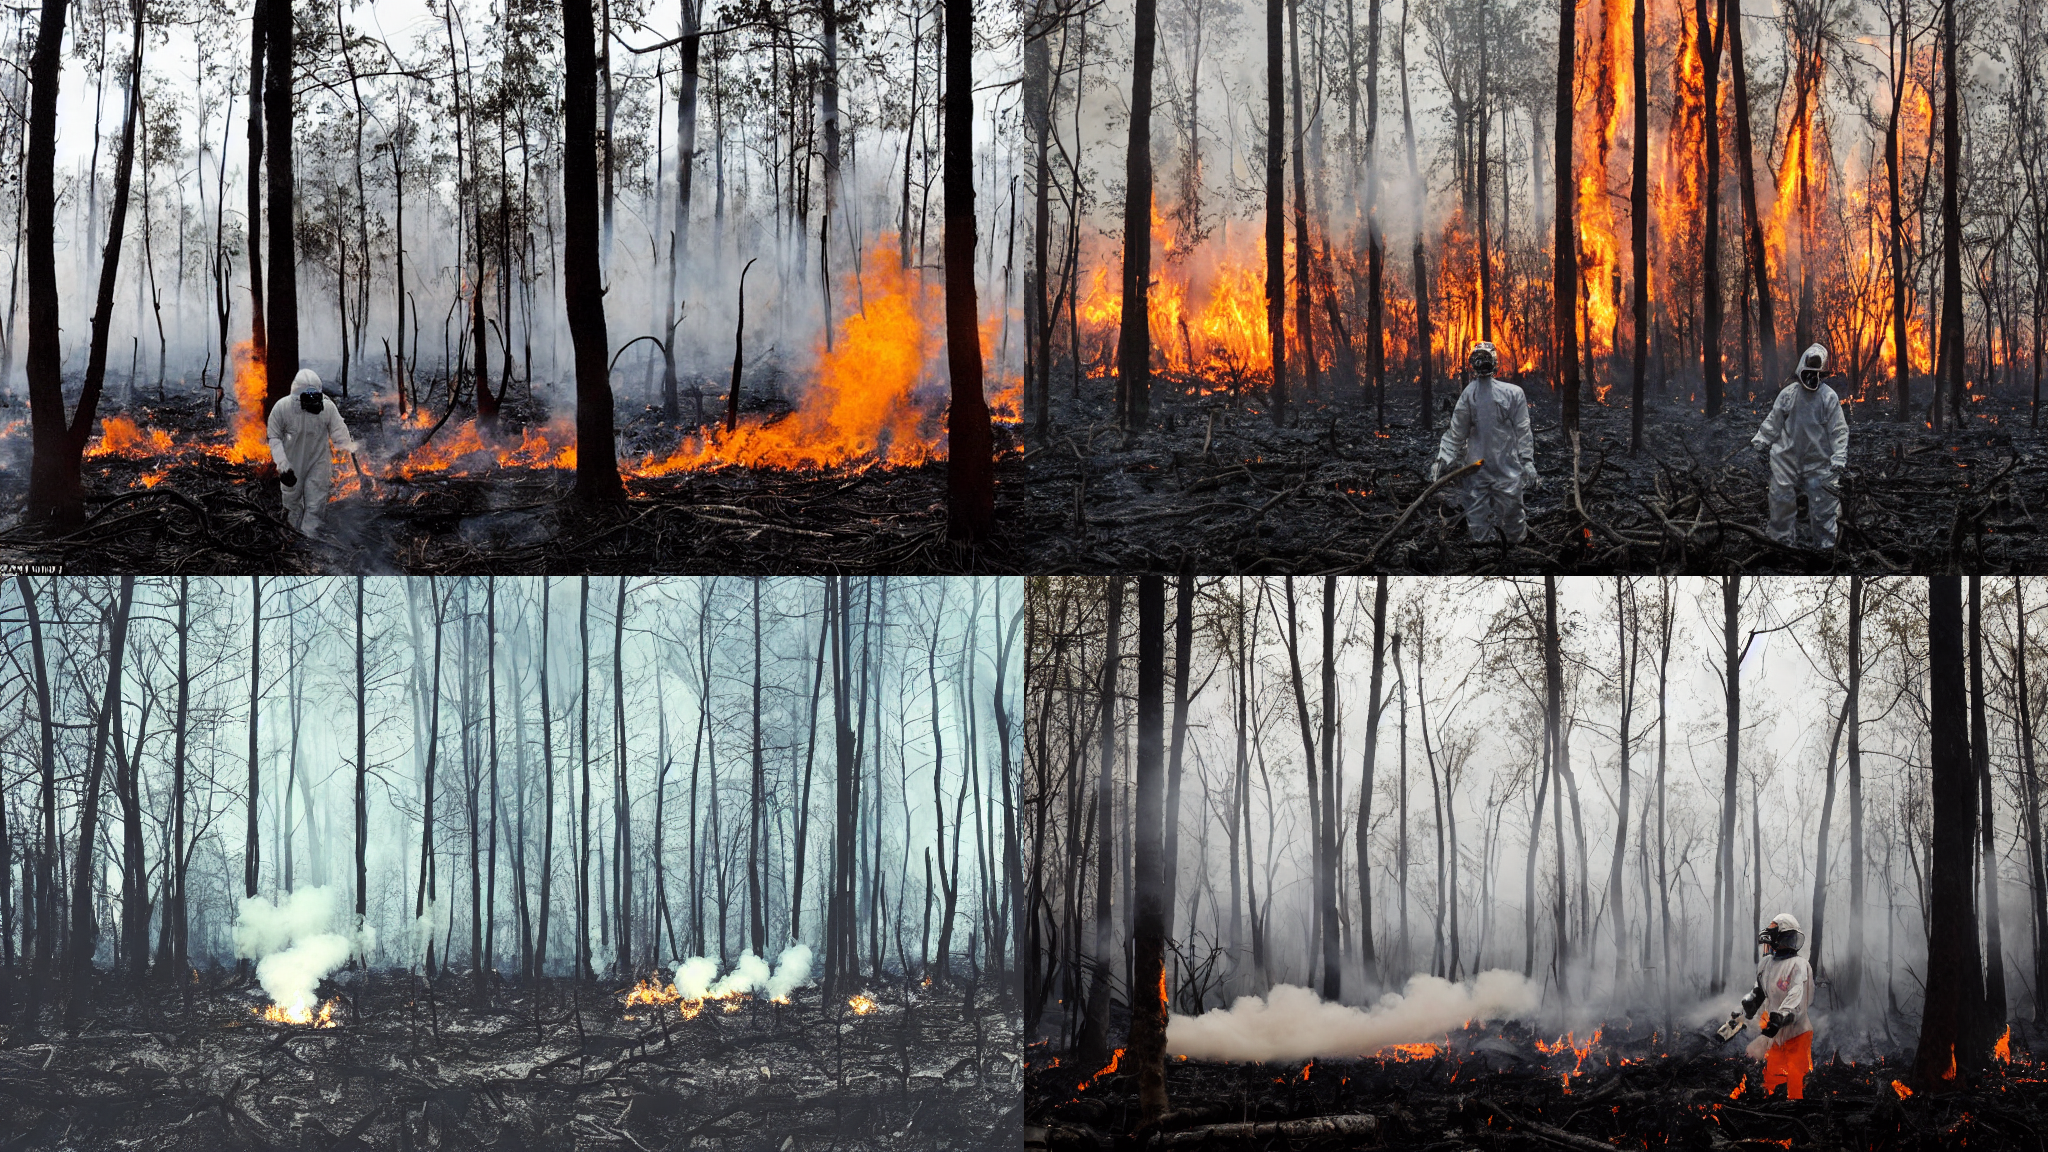

In [253]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


# # https://huggingface.co/docs/diffusers/using-diffusers/reusing_seeds


# prompt_components = [
#     "a floating tram",
#     "descending into an alien world",
#     "Matte Painting",
#     "retrowave color scheme",
#     "purple orange yellow maroon",
#     "full view of vehicle",
# ]

# prompt = ", ".join(prompt_components)

# rows X cols of images. Reduce for speed and memory issues.
rows = 2
cols = 2

num_images = rows*cols

# Make new random seeds in a hacky way. TODO: probably a function to generate seeds without making a generator instance.

generator = torch.Generator(device="cuda")
seeds = [generator.seed() for i in range(num_images)]
# seeds = [2203341424839939, 7696964535120341, 8073992389477540, 6313153470100406]
generator = [torch.Generator(device="cuda").manual_seed(seed) for seed in seeds]

print("Prompt: {}".format(prompt))
print("Seeds: {}".format(seeds))

images = pipe(prompt, generator=generator, num_images_per_prompt=rows*cols, guidance_scale=guidance_scale, negative_prompt=negative_prompt, width=res_width, height=res_height).images

image_grid(images, rows=rows, cols=cols)